In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import keras_tuner as kt
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#!rm -rf /kaggle/working/best_model_LSTM.h5 /kaggle/working/best_model_LSTM_LOAD.h5 /kaggle/working/my_dir.zip

In [5]:
df = pd.read_csv('/kaggle/input/complete-load-data/Total_Load.csv')

In [6]:
start_date = pd.to_datetime('2022-06-07 00:00')

df['Time'] = pd.date_range(start=start_date, periods=len(df), freq='h')

In [7]:
df

,Time,Load
0,2022-06-07 00:00:00,0.000003
1,2022-06-07 01:00:00,2.184715
2,2022-06-07 02:00:00,1.916824
3,2022-06-07 03:00:00,1.785713
4,2022-06-07 04:00:00,1.732656
...,...,...
5248,2023-01-11 16:00:00,13.943496
5249,2023-01-11 17:00:00,16.146784
5250,2023-01-11 18:00:00,15.115618
5251,2023-01-11 19:00:00,14.998644


In [8]:
df.head(24)

,Time,Load
0,2022-06-07 00:00:00,0.000003
1,2022-06-07 01:00:00,2.184715
2,2022-06-07 02:00:00,1.916824
3,2022-06-07 03:00:00,1.785713
4,2022-06-07 04:00:00,1.732656
5,2022-06-07 05:00:00,2.966157
6,2022-06-07 06:00:00,3.967359
7,2022-06-07 07:00:00,5.078456
8,2022-06-07 08:00:00,6.176139
9,2022-06-07 09:00:00,9.050642


In [9]:
def create_dataset(serie, time_steps=1):
    Xs, ys = [], []
    for i in range(len(serie) - time_steps):
        Xs.append(serie.iloc[i:(i + time_steps)].values)
        ys.append(serie.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

In [11]:
time_steps = 15
X, y = create_dataset(df.Load, time_steps)
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1,1))

In [12]:
names = [f"X{i}" for i in range(15)]
data = pd.DataFrame(X_scaled, columns=names)
data["Y"] = y_scaled
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,0.000000,0.086667,0.070081,0.061964,0.058679,0.135048,0.197036,0.265827,0.333787,0.511755,0.498164,0.528913,0.483897,0.413984,0.444726,0.509739
1,0.128993,0.070081,0.061964,0.058679,0.135048,0.197036,0.265827,0.333787,0.511755,0.498164,0.528913,0.483897,0.413984,0.444726,0.509739,0.559839
2,0.113176,0.061964,0.058679,0.135048,0.197036,0.265827,0.333787,0.511755,0.498164,0.528913,0.483897,0.413984,0.444726,0.509739,0.559839,0.535197
3,0.105435,0.058679,0.135048,0.197036,0.265827,0.333787,0.511755,0.498164,0.528913,0.483897,0.413984,0.444726,0.509739,0.559839,0.535197,0.594541
4,0.102302,0.135048,0.197036,0.265827,0.333787,0.511755,0.498164,0.528913,0.483897,0.413984,0.444726,0.509739,0.559839,0.535197,0.594541,0.662246


In [13]:
X.shape

(5238, 15)

In [14]:
X_resh = X_scaled.reshape(len(X), time_steps,1)

In [15]:
X_temp, X_test, y_temp, y_test = train_test_split(X_resh, y_scaled,test_size = 0.1, random_state=42, shuffle=False)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, shuffle=False
)

In [17]:
window_size = time_steps

In [18]:
val_loss = {
    'Simple RNN': 0,
    'LSTM': 0,
    'BILSTM': 0,
    'GRU': 0
}

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [20]:
#!rm -rf /kaggle/working/my_dir

In [21]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

    
def model_builder_simpleRNN(hp):
    model = tf.keras.Sequential()

    # hyperparameters
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', ['relu', 'tanh'])

    model.add(tf.keras.layers.SimpleRNN(units=hp_units, activation=hp_activation, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')

    return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# run the search with GPU
with strategy.scope():
    tuner_simRNN = kt.Hyperband(
        model_builder_simpleRNN,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='simpleRNN'
    )


tuner_simRNN.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps_simRNN = tuner_simRNN.get_best_hyperparameters(num_trials=1)[0]
best_trial_simRNN = tuner_simRNN.oracle.get_best_trials(num_trials=1)[0]
val_loss = {}
val_loss['Simple RNN'] = best_trial_simRNN.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
The validation loss is: {val_loss['Simple RNN']:.6f}
Best number of units: {best_hps_simRNN.get('units')}
Best learning rate: {best_hps_simRNN.get('learning_rate')}
Best activation: {best_hps_simRNN.get('activation')}
""")


Trial 30 Complete [00h 00m 08s]
val_loss: 0.006160655990242958

Best val_loss So Far: 0.005179710686206818
Total elapsed time: 00h 02m 55s

The validation loss is: 0.005180
Best number of units: 128
Best learning rate: 0.001
Best activation: relu



In [22]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_lstm(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.LSTM(units=hp_units, activation=hp_activation, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1, activation='relu'))  # Output layer

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse'
    )

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


with strategy.scope():
    tuner_LSTM = kt.Hyperband(
        model_builder_lstm,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='lstm'
    )

# run the search with GPU
tuner_LSTM.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
    callbacks=[stop_early]
)

# Retrieve best hyperparameters and validation loss
best_hps_LSTM = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]
best_trial_LSTM = tuner_LSTM.oracle.get_best_trials(num_trials=1)[0]

val_loss['LSTM'] = best_trial_LSTM.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
LSTM Validation Loss: {val_loss['LSTM']:.6f}
Optimal Units: {best_hps_LSTM.get('units')}
Optimal Learning Rate: {best_hps_LSTM.get('learning_rate')}
Optimal Activation: {best_hps_LSTM.get('activation')}
""")


Trial 30 Complete [00h 00m 10s]
val_loss: 0.006182133220136166

Best val_loss So Far: 0.005997312255203724
Total elapsed time: 00h 03m 23s

LSTM Validation Loss: 0.005997
Optimal Units: 128
Optimal Learning Rate: 0.01
Optimal Activation: relu



In [23]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_Bilstm(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh']) 

    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=hp_units, activation=hp_activation),
        input_shape=(window_size, 1)
    ))
    model.add(tf.keras.layers.Dense(1, activation='relu')) 

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse'
    )

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# run the search with GPU
with strategy.scope():

    tuner_Bidirectional = kt.Hyperband(
    model_builder_Bilstm,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='Bilstm'
    )
    
tuner_Bidirectional.search(
    X_train, y_train, epochs=50, validation_data=(X_val, y_val),
    callbacks=[stop_early]
)


best_hps_Bidirectional = tuner_Bidirectional.get_best_hyperparameters(num_trials=1)[0]
best_trial_Bidirectional = tuner_Bidirectional.oracle.get_best_trials(num_trials=1)[0]
val_loss['BILSTM'] = best_trial_Bidirectional.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
BiLSTM Validation Loss: {val_loss['BILSTM']:.6f}
Optimal Units: {best_hps_Bidirectional.get('units')}
Optimal Learning Rate: {best_hps_Bidirectional.get('learning_rate')}
Optimal Activation: {best_hps_Bidirectional.get('activation')}
""")


Trial 30 Complete [00h 00m 15s]
val_loss: 0.3966430127620697

Best val_loss So Far: 0.005988257471472025
Total elapsed time: 00h 05m 19s

BiLSTM Validation Loss: 0.005988
Optimal Units: 160
Optimal Learning Rate: 0.001
Optimal Activation: relu



In [24]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_gru(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.Reshape((window_size, 1), input_shape=[window_size]))
    model.add(tf.keras.layers.GRU(units=hp_units, activation=hp_activation))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')
    return model

# run the search with GPU
with strategy.scope():
    tuner_GRU = kt.Hyperband(
        model_builder_gru,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='gru'
    )


tuner_GRU.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps_GRU = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]
best_trial_GRU = tuner_GRU.oracle.get_best_trials(num_trials=1)[0]
val_loss['GRU'] = best_trial_GRU.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
GRU Validation Loss: {val_loss['GRU']}
Optimal Units: {best_hps_GRU.get('units')}
Optimal Learning Rate: {best_hps_GRU.get('learning_rate')}
Optimal Activation: {best_hps_GRU.get('activation')}
""")


Trial 30 Complete [00h 00m 13s]
val_loss: 0.009534349665045738

Best val_loss So Far: 0.005587290041148663
Total elapsed time: 00h 04m 19s

GRU Validation Loss: 0.005587290041148663
Optimal Units: 64
Optimal Learning Rate: 0.01
Optimal Activation: tanh



In [25]:
val_loss

{'Simple RNN': 0.005179710686206818,
 'LSTM': 0.005997312255203724,
 'BILSTM': 0.005988257471472025,
 'GRU': 0.005587290041148663}

In [26]:
best_model_rnn = tuner_simRNN.get_best_models(num_models=1)[0]
best_model_lstm = tuner_LSTM.get_best_models(num_models=1)[0]
best_model_bilstm = tuner_Bidirectional.get_best_models(num_models=1)[0]
best_model_gru = tuner_GRU.get_best_models(num_models=1)[0]

best_hp_rnn = tuner_simRNN.get_best_hyperparameters(num_trials=1)[0]
best_hp_lstm = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]
best_hp_bilstm = tuner_Bidirectional.get_best_hyperparameters(num_trials=1)[0]
best_hp_gru = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_hp_pairs = [
    (best_model_rnn, best_hp_rnn),
    (best_model_lstm, best_hp_lstm),
    (best_model_bilstm, best_hp_bilstm),
    (best_model_gru, best_hp_gru)
]

histories = []
best_models = []

for model, hp in model_hp_pairs:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
        loss='mse'
    )
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    best_models.append(model)
    histories.append(history)

Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0063
Epoch 10/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0063
Epoch 11/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 12/100
122/122 ━━━━━━━━━━━━━━━━━━━

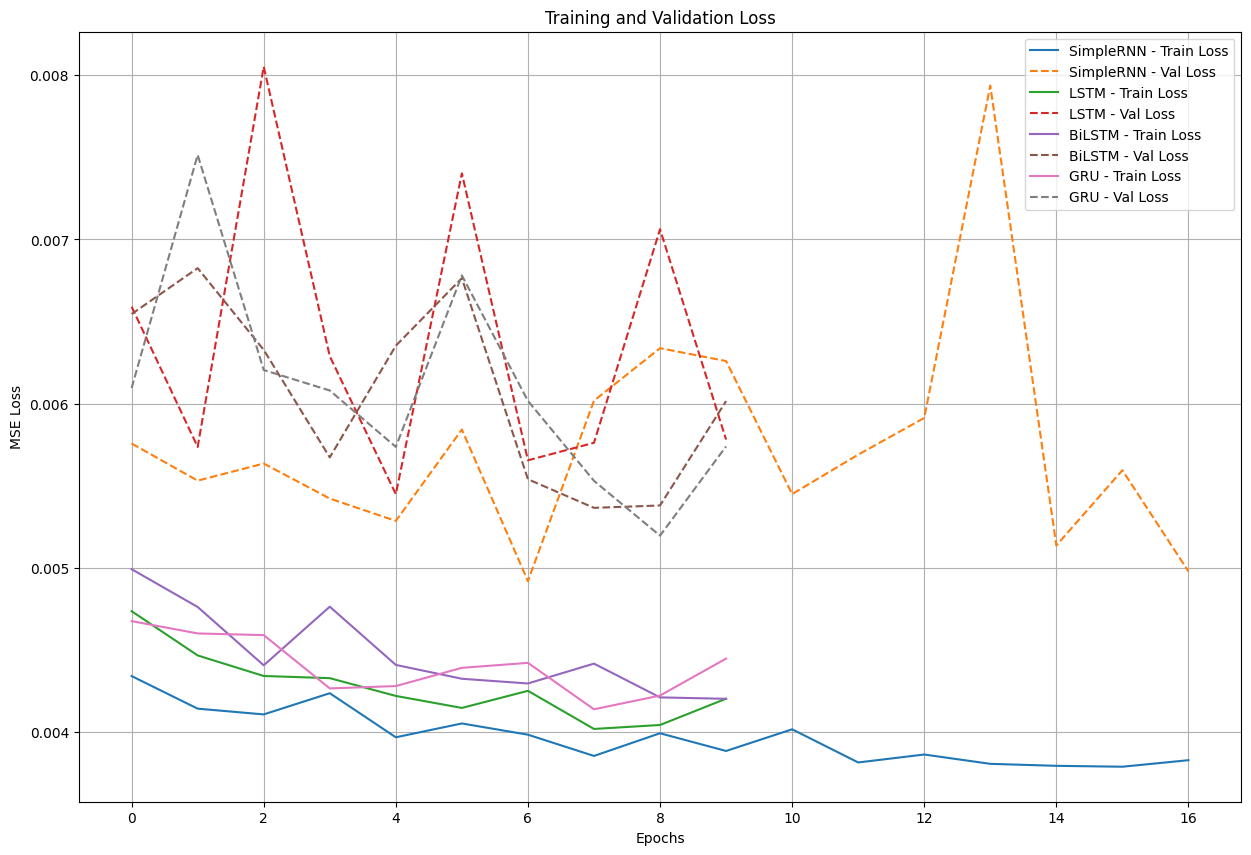

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1500x1000 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_error

model_names = ['SimpleRNN', 'LSTM', 'BiLSTM', 'GRU']
r2_scores = {}
mse_scores = {}
mae_scores = {}

plt.figure(figsize=(15, 10))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Val Loss', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


for i, model in enumerate(best_models):
    y_preds = model.predict(X_test).flatten()
    
    mse = mean_squared_error(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)

    r2_scores[model_names[i]] = r2
    mse_scores[model_names[i]] = mse
    mae_scores[model_names[i]] = mae
plt.figure(figsize=(15, 10))

r2_scores = {}
mse_scores = {}
mae_scores = {}

for i, model in enumerate(best_models):
    y_preds = model.predict(X_test).flatten()

    r2_scores[model_names[i]] = r2_score(y_test, y_preds)
    mse_scores[model_names[i]] = mean_squared_error(y_test, y_preds)
    mae_scores[model_names[i]] = mean_absolute_error(y_test, y_preds)


results = pd.DataFrame({
    'model': list(r2_scores.keys()),
    'r2': list(r2_scores.values()),
    'mse': list(mse_scores.values()),
    'mae': list(mae_scores.values())
})


In [30]:
results

,model,r2,mse,mae
0,SimpleRNN,0.932209,0.004667,0.055730
1,LSTM,0.914219,0.005905,0.060484
2,BiLSTM,0.908795,0.006278,0.064204
3,GRU,0.919971,0.005509,0.060241


All of the model performed well so we will choose the best one based on their mse

In [31]:
import joblib


use_r2 = False

if use_r2:
    best_model_name = max(r2_scores, key=r2_scores.get)
    best_model_index = model_names.index(best_model_name)
    print(f"Best model based on R²: {best_model_name} ({r2_scores[best_model_name]:.6f})")
else:
    best_model_name = min(mse_scores, key=mse_scores.get)
    best_model_index = model_names.index(best_model_name)
    print(f"Best model based on MSE: {best_model_name} ({mse_scores[best_model_name]:.6f})")

best_model = best_models[best_model_index]

best_model.save(f'best_model_{best_model_name}.h5')
print(f"Model saved as best_model_{best_model_name}.h5")


Best model based on MSE: SimpleRNN (0.004667)
Model saved as best_model_SimpleRNN.h5


# Loaanding and testing the model

In [ ]:
df

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


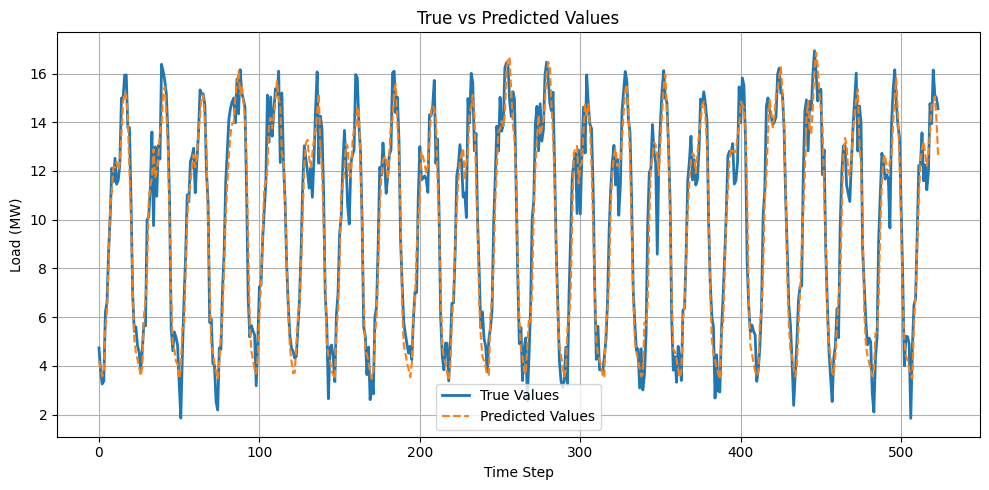

In [32]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

model = load_model('/kaggle/working/best_model_SimpleRNN.h5', custom_objects={'mse': MeanSquaredError()})
y_pred = model.predict(X_test).flatten()
# y_pred[y_pred < 0] = 0


plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='True Values', linewidth=2)
plt.plot(scaler.inverse_transform(y_pred.reshape(-1,1)), label='Predicted Values', linestyle='--')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 1) Forcasting the 22 of future

In [33]:
future = pd.DataFrame()
future['Load'] = y_pred
future

,Load
0,0.211786
1,0.190054
2,0.171976
3,0.182019
4,0.295063
...,...
519,0.861982
520,0.864887
521,0.883493
522,0.825075


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


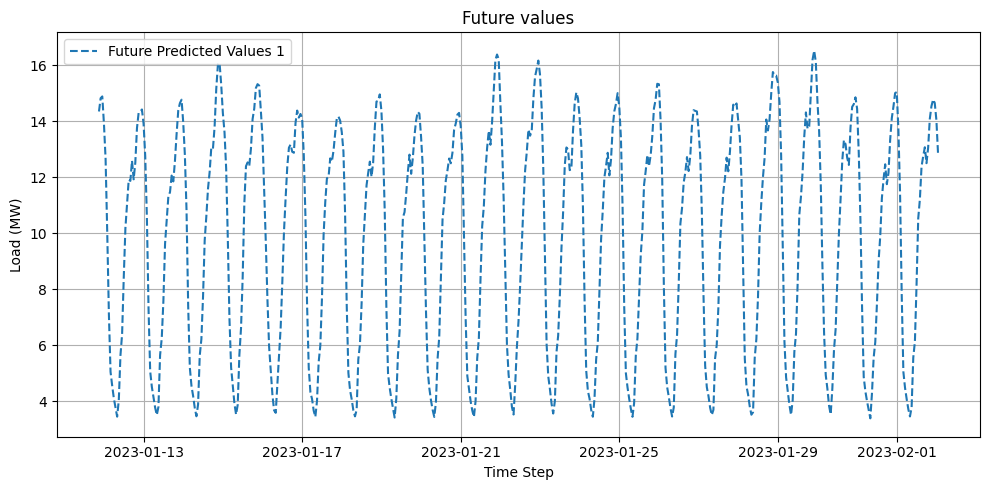

In [35]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError


model = load_model('/kaggle/working/best_model_SimpleRNN.h5', custom_objects={'mse': MeanSquaredError()})
X, y = create_dataset(future.Load, time_steps)
y_pred1 = model.predict(X).flatten()
# y_pred1[y_pred1 < 0] = 0

plt.figure(figsize=(10, 5))
plt.plot(pd.date_range(start='2023-01-11 21:00:00', periods = len(y_pred1), freq='h'),scaler.inverse_transform(y_pred1.reshape(-1,1)), label='Future Predicted Values 1', linestyle='--')
plt.title('Future values')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) next 22 days

In [36]:
pd.date_range(start='2023-01-11 21:00:00', periods = len(y_pred1), freq='h')[-1]

Timestamp('2023-02-02 01:00:00')

In [37]:
future2 = pd.DataFrame()
future2['Load'] = y_pred1
future2

,Load
0,0.839748
1,0.869093
2,0.872997
3,0.812973
4,0.734865
...,...
504,0.851415
505,0.866081
506,0.858642
507,0.820607


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


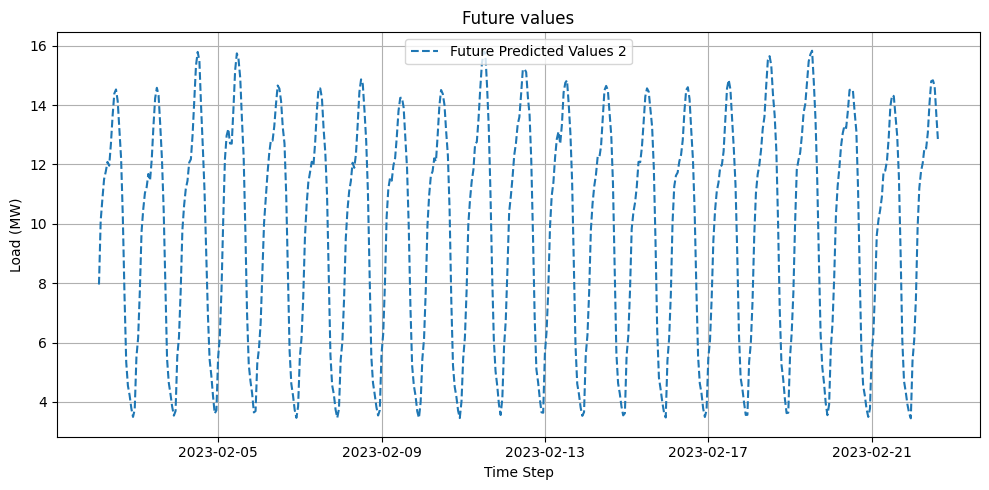

In [38]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

X, y = create_dataset(future2.Load, time_steps)
y_pred2 = model.predict(X).flatten()
# y_pred2[y_pred2 < 0] = 0

plt.figure(figsize=(10, 5))
plt.plot(pd.date_range(start='2023-02-02 02:00:00', periods = len(y_pred2), freq='h'),scaler.inverse_transform(y_pred2.reshape(-1,1)), label='Future Predicted Values 2', linestyle='--')
plt.title('Future values')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saving model and directory

In [ ]:
!zip -r /kaggle/working/my_dir.zip /kaggle/working/my_dir

# Training the best model for more epochs

* Best number of units: 128
* Best learning rate: 0.001
* Best activation: relu


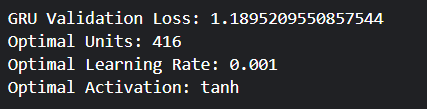
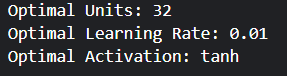

In [40]:
from tensorflow.keras.layers import Dense, SimpleRNN, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(SimpleRNN(units = 128, return_sequences=False, activation = 'relu',input_shape=(window_size, 1)))
model.add(Dense(1, activation = 'relu'))

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=20,          
    restore_best_weights=True 
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,          
    batch_size=32,       
    callbacks=[early_stopping]  
)


Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0265 - mae: 0.1180 - val_loss: 0.0101 - val_mae: 0.0805
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mae: 0.0656 - val_loss: 0.0095 - val_mae: 0.0769
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mae: 0.0587 - val_loss: 0.0070 - val_mae: 0.0668
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0557 - val_loss: 0.0064 - val_mae: 0.0647
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0541 - val_loss: 0.0069 - val_mae: 0.0681
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0524 - val_loss: 0.0059 - val_mae: 0.0627
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mae: 0.0520 - val_loss: 0.0053 - val_mae: 0.0593
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mae: 0.0522 - val_loss: 0.0053 - val_mae: 0.0587
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

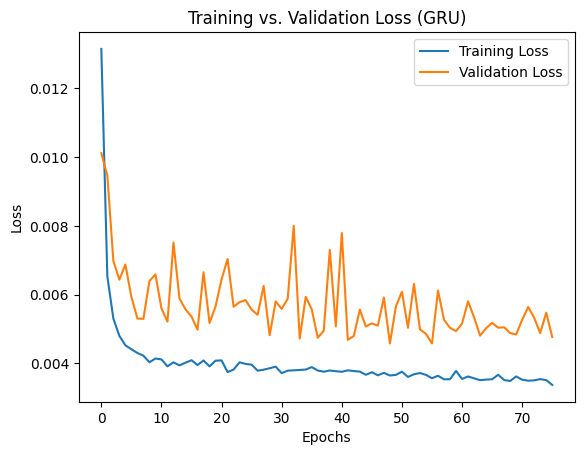

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


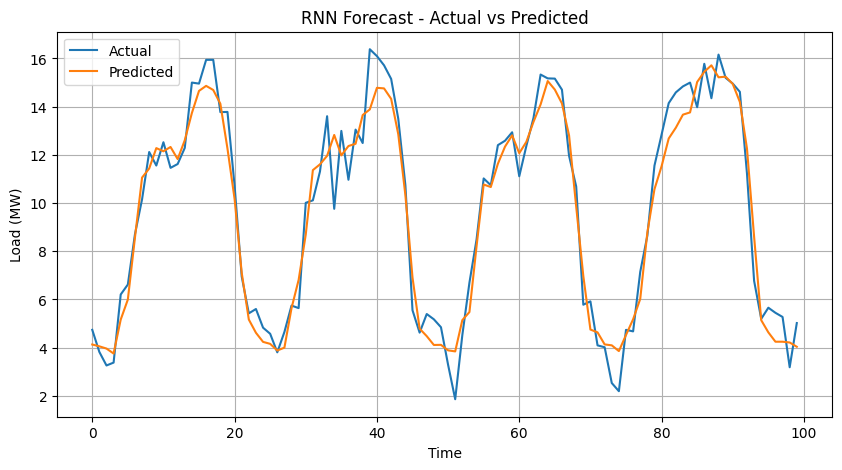

In [49]:
predictions = model.predict(X_test)


y_pred_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(y_pred_inverse[:100], label='Predicted')
plt.title("RNN Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


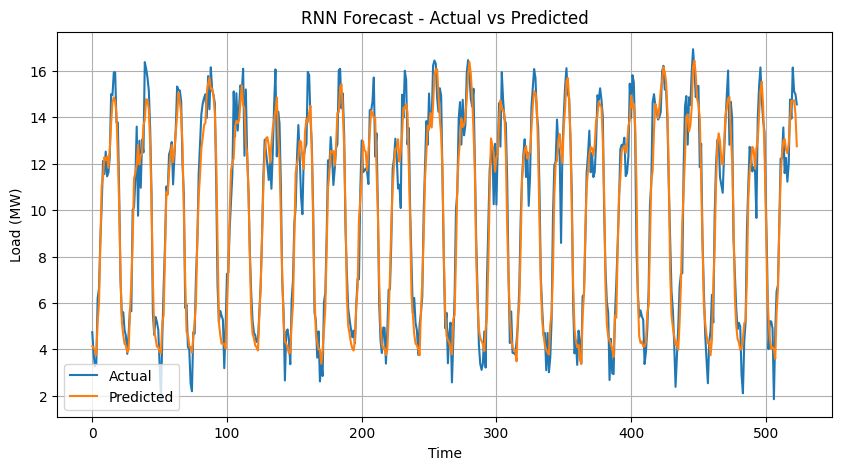

In [50]:
predictions = model.predict(X_test)


y_pred_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title("RNN Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


In [52]:
from sklearn.metrics import r2_score

mse = np.mean((predictions - y_test) ** 2)
mae = np.mean(np.abs(predictions - y_test))
r2 = r2_score(y_test, predictions)

print(f"MSE (RNN): {mse:.4f}")
print(f"MAE (RNN): {mae:.4f}")
print(f"R² Score (RNN): {r2:.4f}")

MSE (RNN): 0.0044
MAE (RNN): 0.0547
R² Score (RNN): 0.9360


In [54]:
model.save('best_model_RNN_LOAD.h5')